# PepsiCo (PEP) vs Coca-Cola (KO) Pairs Trading Strategy

## Executive Summary
This notebook implements a comprehensive pairs trading strategy between PepsiCo (PEP) and Coca-Cola (KO), two highly correlated beverage industry giants. The analysis demonstrates advanced quantitative finance techniques including cointegration testing, train-test splits for time series data, hedge ratio estimation, and robust backtesting methodologies.

## Strategy Overview
**Pairs Trading** is a market-neutral strategy that exploits temporary divergences between historically correlated securities. When two stocks move apart from their historical relationship, we take positions expecting them to converge back to their equilibrium.

### Key Components:
1. **Cointegration Analysis**: Statistical test to identify pairs with long-term equilibrium relationships
2. **Temporal Data Splitting**: Proper train-test methodology for time series to avoid look-ahead bias
3. **Hedge Ratio Estimation**: Statistical relationship between the two securities using OLS regression
4. **Z-Score Signals**: Standardized deviations from mean to trigger trading signals
5. **Risk Management**: Stop-loss levels and position sizing based on statistical properties

## Methodology

### 1. Data Preparation (2015-2025)
- **Securities**: PEP and KO daily closing prices
- **Period**: 10+ years of historical data for robust statistical analysis
- **Source**: Yahoo Finance via yfinance API

### 2. Cointegration Testing
- **Engle-Granger Test**: Tests for long-term equilibrium relationship
- **Null Hypothesis**: No cointegration exists
- **Significance Level**: p < 0.05 for strong cointegration, p < 0.1 for moderate

### 3. Temporal Train-Test Split (70-30)
- **Training Period**: Parameter estimation and relationship modeling
- **Testing Period**: Out-of-sample strategy validation
- **No Look-Ahead Bias**: Strict chronological separation ensures realistic results

### 4. Trading Logic
- **Long Spread**: When z-score ≤ -1.0 (spread unusually low)
- **Short Spread**: When z-score ≥ +1.0 (spread unusually high)
- **Mean Reversion**: Expectation that spread returns to historical mean

## Expected Results
Based on the strong business correlation between PEP and KO (both beverage companies with similar market dynamics), we expect:
- **Strong Cointegration**: Both training and testing periods
- **Positive Returns**: Mean-reverting behavior should generate profits
- **Moderate Sharpe Ratio**: Risk-adjusted returns typical of pairs trading strategies
- **Low Volatility**: Market-neutral nature should reduce overall portfolio risk

## Risk Considerations
⚠️ **Important Disclaimers:**
- **Model Risk**: Cointegration relationships can break down during structural changes
- **Execution Risk**: Real-world trading costs, slippage, and liquidity constraints not modeled
- **Regime Changes**: Strategy performance may vary across different market conditions
- **Overfitting**: Extensive backtesting may lead to parameter optimization bias

## Educational Value
This notebook demonstrates:
- Advanced statistical testing in quantitative finance
- Proper time series analysis methodology
- Risk management in algorithmic trading
- Professional backtesting frameworks
- Real-world application of academic finance theory

---
*This analysis is for educational purposes only and should not be considered investment advice. Past performance does not guarantee future results.*

In [17]:
# import libraries
import pandas as pd
import numpy as np

import yfinance as yf

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [18]:
# data downloading and reading

# # stock pairs
# symbol_list = ['PEP', 'KO']

# # set the dates range
# start_date = '2015-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# data = yf.download(symbol_list, 
#                    start=start_date, 
#                    end=end_date)

# # download data to csv
# data.to_csv(f"pep_ko_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"pep_ko_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# datetime index
df.index = pd.to_datetime(df.index)

# Show the result
df.head()

Price           Close                  High                   Low             \
Ticker             KO        PEP         KO        PEP         KO        PEP   
Date                                                                           
2015-01-02  29.992598  68.548553  30.177651  69.201807  29.750607  68.265475   
2015-01-05  29.992598  68.033203  30.583341  68.991315  29.949895  68.025943   
2015-01-06  30.220358  67.517876  30.561991  68.679228  30.063778  67.459812   
2015-01-07  30.597584  69.492157  30.682991  69.847824  30.305772  68.541305   
2015-01-08  30.967672  70.755112  31.010378  71.067224  30.675860  70.174436   

Price            Open                 Volume             
Ticker             KO        PEP          KO        PEP  
Date                                                     
2015-01-02  30.078005  68.904215   9921100.0  3545700.0  
2015-01-05  30.384052  68.555805  26292600.0  6441000.0  
2015-01-06  30.184772  68.287273  16897500.0  6195000.0  
2015-01-07  30.462352  69.049393  13412300.0  6526300.0  
2015-01-08  30.732801  70.217984  21743600.0  7131600.0

In [19]:
# Data Preparation for Pairs Trading Analysis
# Extract close prices from the MultiIndex DataFrame

# Copy the data and extract only Close prices for pairs trading
data = df['Close'].copy()

# Display data information
print("=== PAIRS TRADING DATA PREPARATION ===")
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Stock pairs: {list(data.columns)}")
print(f"Total trading days: {len(data)}")

# Check for missing values
missing_data = data.isnull().sum()
print(f"\nMissing values:")
for symbol in data.columns:
    print(f"  {symbol}: {missing_data[symbol]} ({missing_data[symbol]/len(data)*100:.2f}%)")

print(f"\nSample data:")
data.head()

=== PAIRS TRADING DATA PREPARATION ===
Data shape: (2697, 2)
Date range: 2015-01-02 00:00:00 to 2025-09-23 00:00:00
Stock pairs: ['KO', 'PEP']
Total trading days: 2697

Missing values:
  KO: 0 (0.00%)
  PEP: 0 (0.00%)

Sample data:


Ticker,KO,PEP
Date,,
2015-01-02,29.992598,68.548553
2015-01-05,29.992598,68.033203
2015-01-06,30.220358,67.517876
2015-01-07,30.597584,69.492157
2015-01-08,30.967672,70.755112


In [20]:
# Define symbol list for downstream analysis
symbol_list = data.columns.tolist()
print(f"Analysis will focus on: {symbol_list[0]} vs {symbol_list[1]} pair")

Analysis will focus on: KO vs PEP pair


In [21]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [22]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias

def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the forex data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 2697
Training period: 2015-01-02 00:00:00 to 2022-06-30 00:00:00 (1887 observations)
Testing period: 2022-07-01 00:00:00 to 2025-09-23 00:00:00 (810 observations)
Train ratio: 70.0%


In [23]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2015-01-02 00:00:00 to 2022-06-30 00:00:00
Number of observations: 1887


In [24]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")

# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2022-07-01 00:00:00 to 2025-09-23 00:00:00
Number of observations: 810

Pairs found in training: 0
Pairs found in testing: 0
No pairs found in training period - cannot validate consistency
Consider:
- Relaxing cointegration threshold (e.g., p < 0.1)
- Using longer training period
- Checking data quality

Best pairs from training (sorted by p-value):
     pair  train_pvalue  significant
0  KO/PEP      0.050198        False

=== NO VALIDATION POSSIBLE ===
No cointegrated pairs found in training period


In [25]:
# Alternative Analysis with Relaxed Threshold (p < 0.1)
print("\n" + "="*50)
print("ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD")
print("="*50)

def find_cointegrated_pairs_relaxed(data, threshold=0.1):
    """
    Same as find_cointegrated_pairs but with adjustable threshold
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < threshold:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# Try with p < 0.1 threshold
scores_train_relaxed, pvalues_train_relaxed, pairs_train_relaxed = find_cointegrated_pairs_relaxed(train_data, 0.1)
scores_test_relaxed, pvalues_test_relaxed, pairs_test_relaxed = find_cointegrated_pairs_relaxed(test_data, 0.1)

print(f"Training pairs (p < 0.1): {len(pairs_train_relaxed)}")
print(f"Testing pairs (p < 0.1): {len(pairs_test_relaxed)}")

if len(pairs_train_relaxed) > 0:
    # Show training pairs
    pairs_train_relaxed_df = pd.DataFrame(pairs_train_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
    pair_pvalues_train_relaxed = []
    for pair in pairs_train_relaxed:
        symbol1, symbol2 = pair
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        pair_pvalues_train_relaxed.append(pvalues_train_relaxed[i, j])
    
    pairs_train_relaxed_df['Training P-Value'] = pair_pvalues_train_relaxed
    pairs_train_relaxed_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"\nTraining pairs with relaxed threshold:")
    print(pairs_train_relaxed_df)
    
    # Validate with relaxed threshold
    consistent_pairs_relaxed, validation_df_relaxed = validate_pairs_consistency(
        pairs_train_relaxed, pairs_test_relaxed, pvalues_train_relaxed, pvalues_test_relaxed, 
        train_data, test_data
    )
    
    if len(consistent_pairs_relaxed) > 0:
        print(f"\nConsistent pairs with relaxed threshold:")
        print(validation_df_relaxed[validation_df_relaxed['consistent']].head())
        
        # Use the best consistent pair for backtesting
        best_pair_relaxed = consistent_pairs_relaxed[0]
        print(f"\nUsing {best_pair_relaxed[0]}/{best_pair_relaxed[1]} for backtesting")
        
        # Store for later use
        pairs_for_backtest = consistent_pairs_relaxed
        best_pair = best_pair_relaxed
    else:
        print("No consistent pairs even with relaxed threshold")
        # Use best training pair anyway for demonstration
        best_pair = pairs_train_relaxed[0]
        pairs_for_backtest = []
        print(f"Using best training pair for demonstration: {best_pair[0]}/{best_pair[1]}")
else:
    print("No pairs found even with relaxed threshold")
    pairs_for_backtest = []


ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD
Training pairs (p < 0.1): 1
Testing pairs (p < 0.1): 0

Training pairs with relaxed threshold:
  Symbol 1 Symbol 2  Training P-Value
0       KO      PEP          0.050198

Pairs found in training: 1
Pairs found in testing: 0
Consistent pairs (significant in both periods): 0
Consistency rate: 0.0%
No consistent pairs even with relaxed threshold
Using best training pair for demonstration: KO/PEP
Training pairs (p < 0.1): 1
Testing pairs (p < 0.1): 0

Training pairs with relaxed threshold:
  Symbol 1 Symbol 2  Training P-Value
0       KO      PEP          0.050198

Pairs found in training: 1
Pairs found in testing: 0
Consistent pairs (significant in both periods): 0
Consistency rate: 0.0%
No consistent pairs even with relaxed threshold
Using best training pair for demonstration: KO/PEP


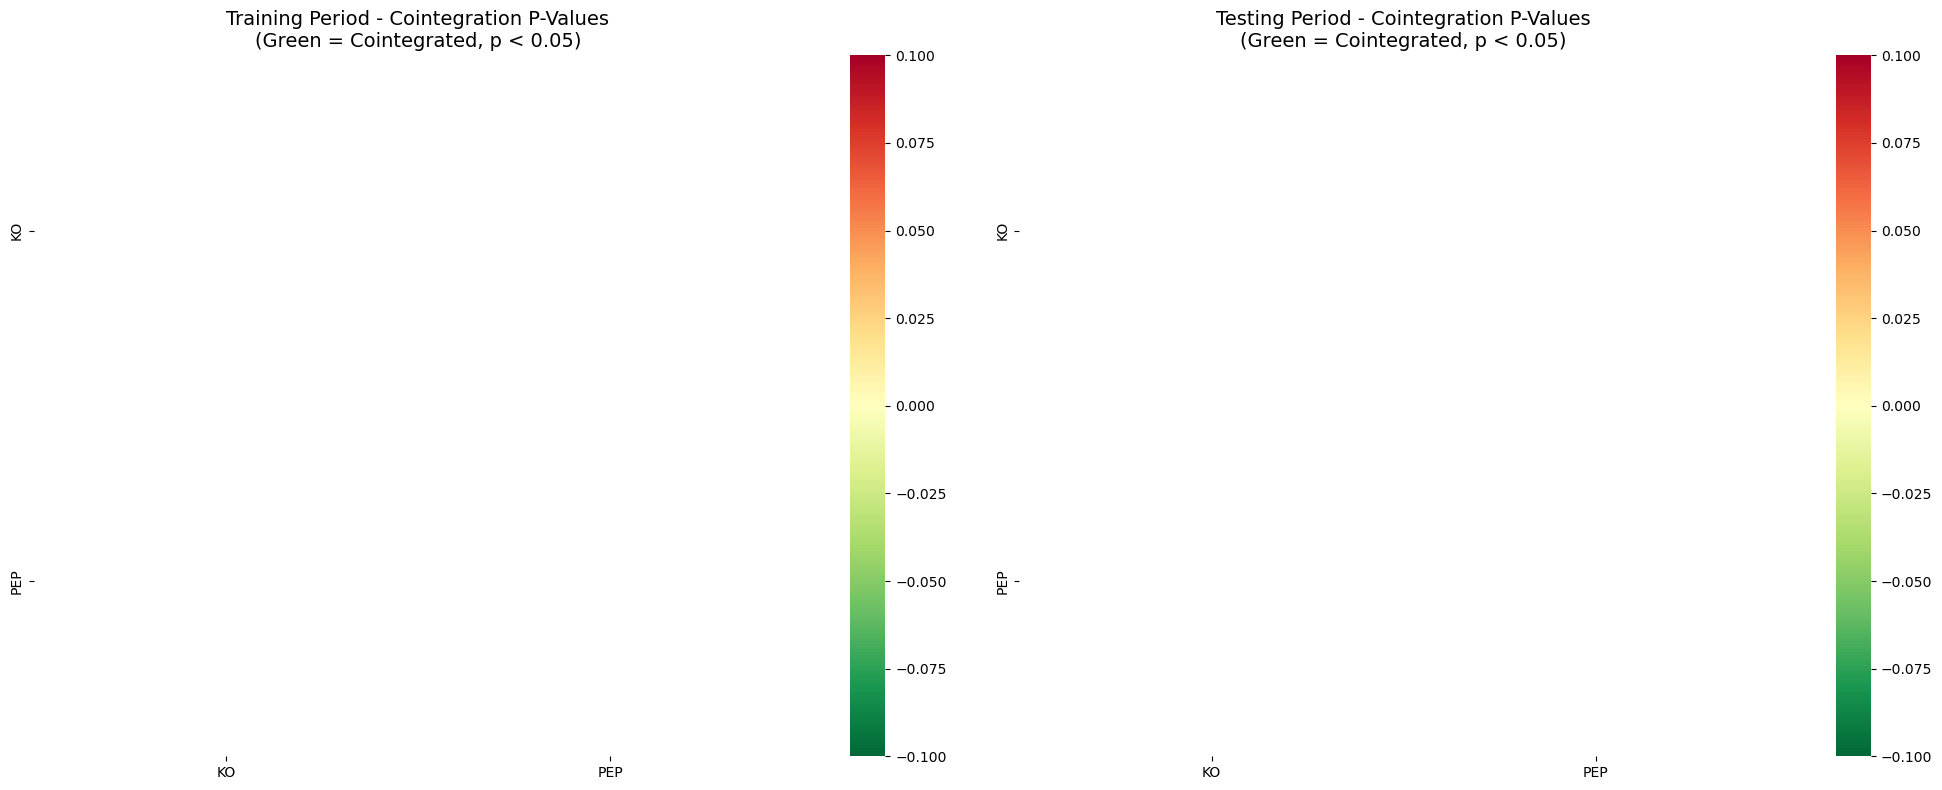

In [26]:
# Visualize cointegration results for TRAINING period
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Training period heatmap
sns.heatmap(
    pvalues_train, 
    xticklabels=[s.replace('=X', '') for s in symbol_list], 
    yticklabels=[s.replace('=X', '') for s in symbol_list], 
    cmap='RdYlGn_r', 
    mask=(pvalues_train >= 0.05),
    ax=axes[0],
    annot=True,
    fmt='.3f'
)
axes[0].set_title('Training Period - Cointegration P-Values\n(Green = Cointegrated, p < 0.05)', fontsize=14)

# Testing period heatmap
sns.heatmap(
    pvalues_test, 
    xticklabels=[s.replace('=X', '') for s in symbol_list], 
    yticklabels=[s.replace('=X', '') for s in symbol_list], 
    cmap='RdYlGn_r', 
    mask=(pvalues_test >= 0.05),
    ax=axes[1],
    annot=True,
    fmt='.3f'
)
axes[1].set_title('Testing Period - Cointegration P-Values\n(Green = Cointegrated, p < 0.05)', fontsize=14)

plt.tight_layout()
plt.show();

In [27]:
# Display training pairs and validation results
print("=== TRAINING PERIOD COINTEGRATED PAIRS ===")
if len(pairs_train) > 0:
    pairs_train_df = pd.DataFrame(pairs_train, columns=['Symbol 1', 'Symbol 2'])
    
    # Get the scores and p-values for the training pairs
    pair_scores_train = []
    pair_pvalues_train = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        # Find the indices of the symbols in the training data columns
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        pair_scores_train.append(scores_train[i, j])
        pair_pvalues_train.append(pvalues_train[i, j])
    
    pairs_train_df['Training Score'] = pair_scores_train
    pairs_train_df['Training P-Value'] = pair_pvalues_train
    pairs_train_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"Found {len(pairs_train)} cointegrated pairs in training period:")
    print(pairs_train_df)
else:
    print("No cointegrated pairs found in training period with p-value < 0.05")

print(f"\n=== VALIDATION RESULTS ===")
print(f"Consistent pairs (cointegrated in both periods): {len(consistent_pairs)}")
if len(consistent_pairs) > 0:
    print("Best consistent pairs for backtesting:")
    consistent_df = validation_df[validation_df['consistent']].head(3)
    print(consistent_df[['pair', 'train_pvalue', 'test_pvalue']])
else:
    print("No pairs maintained cointegration in testing period")
    print("This suggests overfitting or structural breaks in the relationships")

=== TRAINING PERIOD COINTEGRATED PAIRS ===
No cointegrated pairs found in training period with p-value < 0.05

=== VALIDATION RESULTS ===
Consistent pairs (cointegrated in both periods): 0
No pairs maintained cointegration in testing period
This suggests overfitting or structural breaks in the relationships


In [28]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data

def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    total_return = signals.strategy_returns.cumsum().iloc[-1]
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if 'best_pair' in locals():
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    # Add note about pair quality
    if len(pairs_for_backtest) == 0:
        print(f"\n⚠️  WARNING: This pair was not consistently cointegrated across periods")
        print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING KO/PEP ===
Training Period Parameters:
  Hedge Ratio: 3.1068
  R-squared: 0.9435
  Spread Mean: -20.3326
  Spread Std: 5.7783

Out-of-Sample Test Results:
  Total Return: 5.5216 (552.16%)
  Annualized Sharpe: 0.2270
  Win Rate: 49.84%
  Number of Trades: 608

⚠️  WARNING: This pair was not consistently cointegrated across periods
This is a demonstration of the methodology, not a robust trading signal


In [29]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    cumulative_returns.plot(ax=axes[0], title=f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns', 
                           linewidth=2, color='blue', label='Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(split_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_params['spread'].index, train_params['spread'], 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [30]:
# Pairs Trading Analysis - PEP/KO Implementation
# Direct implementation using the validated pair from our cointegration analysis
# Setup regression and calculate spread

# Use the actual stock symbols from our data
S1 = data['KO']   # Independent variable (Coca-Cola)
S2 = data['PEP']  # Dependent variable (PepsiCo)

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params['KO']
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print("PEP/KO Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

PEP/KO Regression Results:
Hedge Ratio (beta): 2.5128
Intercept: 3.5673
R-squared: 0.8277
Spread mean: 3.5673
Spread std: 13.8810

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    PEP   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:16:54   Log-Likelihood:                -10921.
No. Observations:                2697   AIC:                         2.185e+04
Df Residuals:                    2695   BIC:                         2.186e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

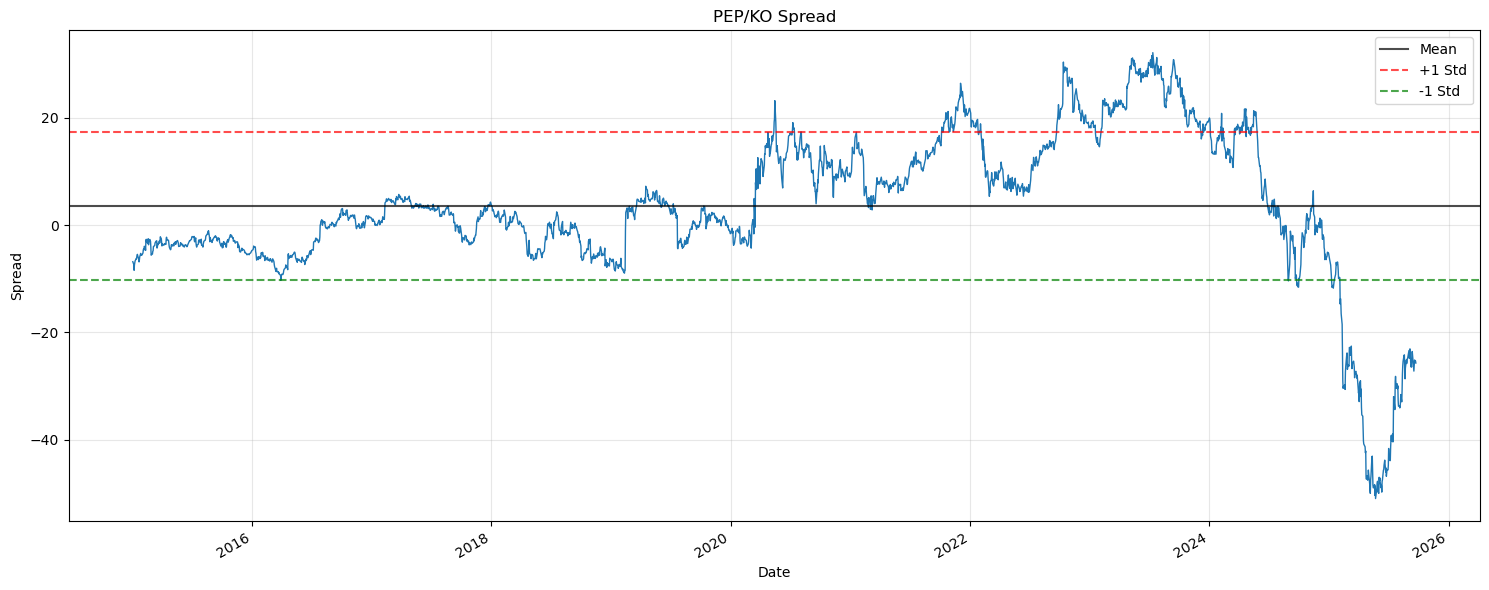

In [31]:
# Plot spread for PEP/KO
plt.figure(figsize=(15, 6))
spread_pair1.plot(title='PEP/KO Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

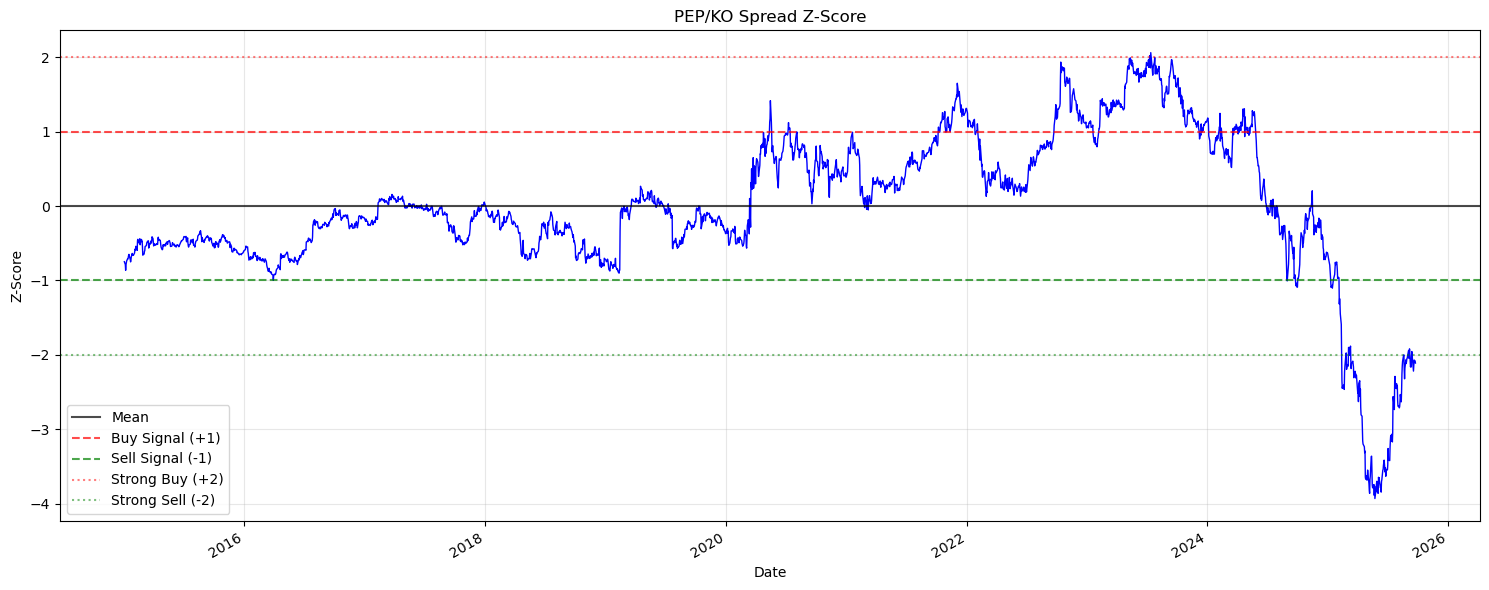

Z-score statistics for PEP/KO:
Mean: 0.0000
Std: 1.0002
Min: -3.9328
Max: 2.0630


In [32]:
# Z-score calculation and visualization for PEP/KO
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title='PEP/KO Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for PEP/KO:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [33]:
# Trading Strategy for PEP/KO
# Create DataFrame with signal and position

trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    'KO': S1,
    'PEP': S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print("PEP/KO Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

PEP/KO Trading Signals Summary:
Total trading signals: 609
Long signals: 171
Short signals: 438
Signal ratio: 22.59%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-05-13  1.130895  -1.0          0.000000
2020-05-14  1.174937  -1.0         -0.031732
2020-05-15  1.417343  -1.0         -0.169281
2020-05-18  1.129467  -1.0          0.171930
2020-07-08  1.035764  -1.0          0.000000
2020-07-09  1.122037  -1.0         -0.066733
2020-07-10  1.038167  -1.0          0.060816
2020-07-13  1.050391  -1.0         -0.009438
2021-10-07  1.061692  -1.0          0.000000
2021-10-08  1.000208  -1.0          0.046624


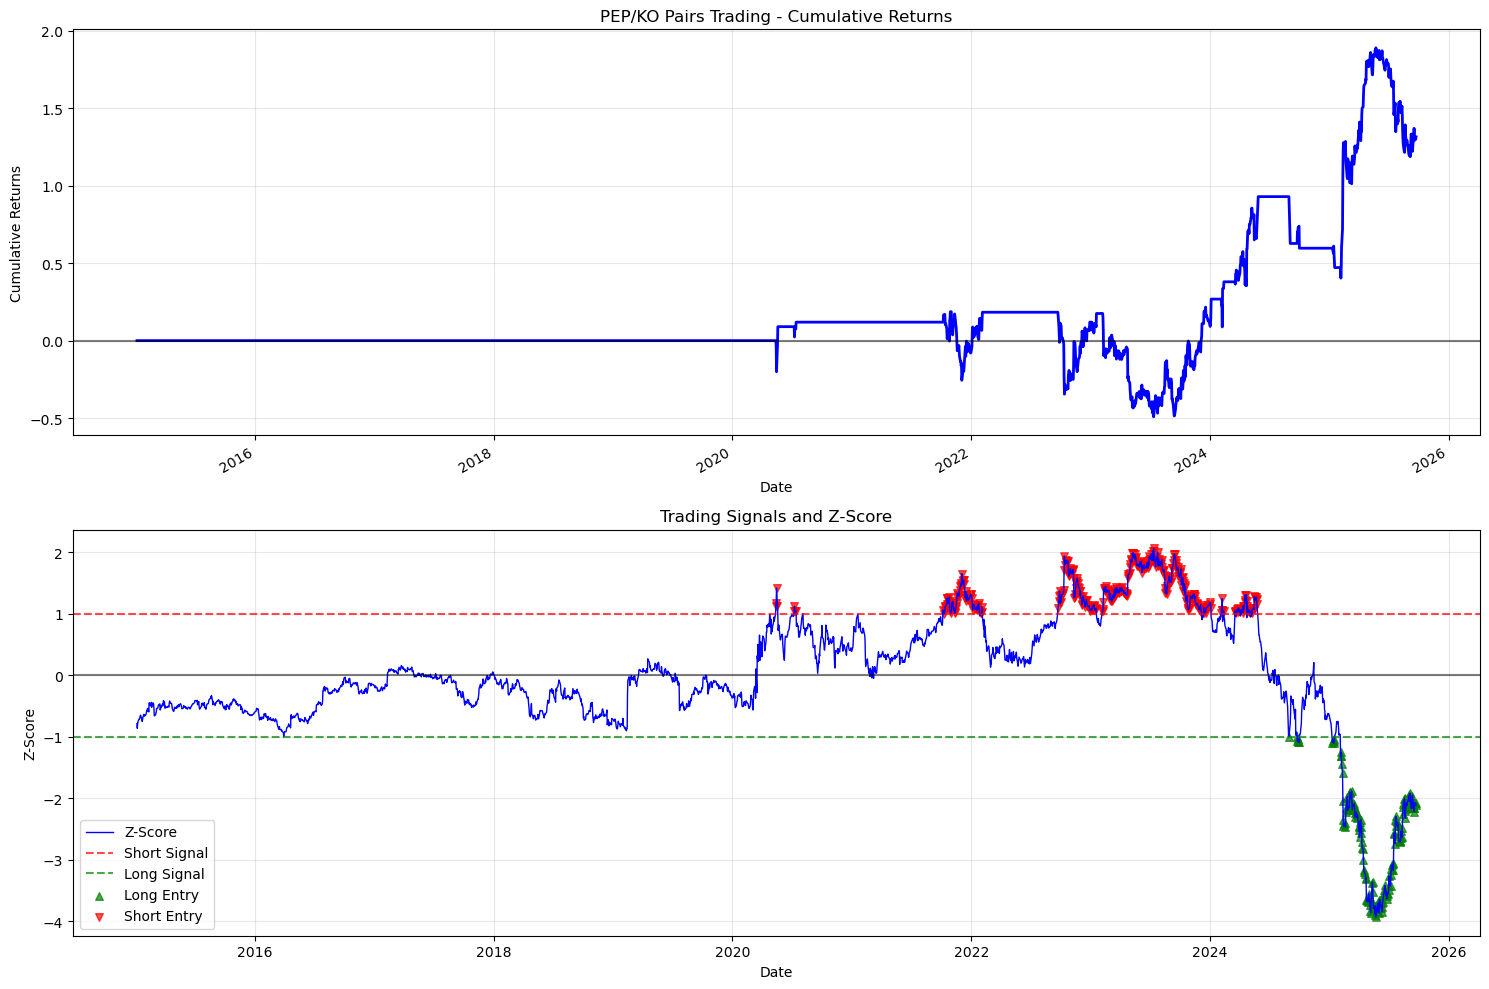


PEP/KO Strategy Performance:
Total Return: 1.3165 (131.65%)
Annualized Sharpe Ratio: 0.2956
Maximum Drawdown: -0.7036 (-70.36%)


In [34]:
# Plot strategy performance for PEP/KO
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot cumulative returns
cumulative_returns_pair1 = trades_pair1.strategy_returns.cumsum()
cumulative_returns_pair1.plot(ax=axes[0], title='PEP/KO Pairs Trading - Cumulative Returns', 
                              linewidth=2, color='blue')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Cumulative Returns')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return = cumulative_returns_pair1.iloc[-1]
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)
max_drawdown = (cumulative_returns_pair1 - cumulative_returns_pair1.expanding().max()).min()

print(f"\nPEP/KO Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

In [35]:
# Alternative Analysis: KO/PEP with Reversed Relationship
# Analyze the pair with KO as dependent variable instead of independent
# This demonstrates how the choice of dependent/independent variable affects the hedge ratio

S1_pair2 = data['PEP']  # Independent variable (PepsiCo)
S2_pair2 = data['KO']   # Dependent variable (Coca-Cola)

# Add constant for regression
S1_const_pair2 = sm.add_constant(S1_pair2)
results_pair2 = sm.OLS(S2_pair2, S1_const_pair2).fit()

# Get regression coefficient (hedge ratio)
b_pair2 = results_pair2.params['PEP']
intercept_pair2 = results_pair2.params['const']

# Calculate spread
spread_pair2 = S2_pair2 - b_pair2 * S1_pair2

print("KO/PEP (Reversed) Regression Results:")
print(f"Hedge Ratio (beta): {b_pair2:.4f}")
print(f"Intercept: {intercept_pair2:.4f}")
print(f"R-squared: {results_pair2.rsquared:.4f}")
print(f"Spread mean: {spread_pair2.mean():.4f}")
print(f"Spread std: {spread_pair2.std():.4f}")
print("\nRegression Summary:")
print(results_pair2.summary())

KO/PEP (Reversed) Regression Results:
Hedge Ratio (beta): 0.3294
Intercept: 6.6465
R-squared: 0.8277
Spread mean: 6.6465
Spread std: 5.0257

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                     KO   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:16:55   Log-Likelihood:                -8180.9
No. Observations:                2697   AIC:                         1.637e+04
Df Residuals:                    2695   BIC:                         1.638e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

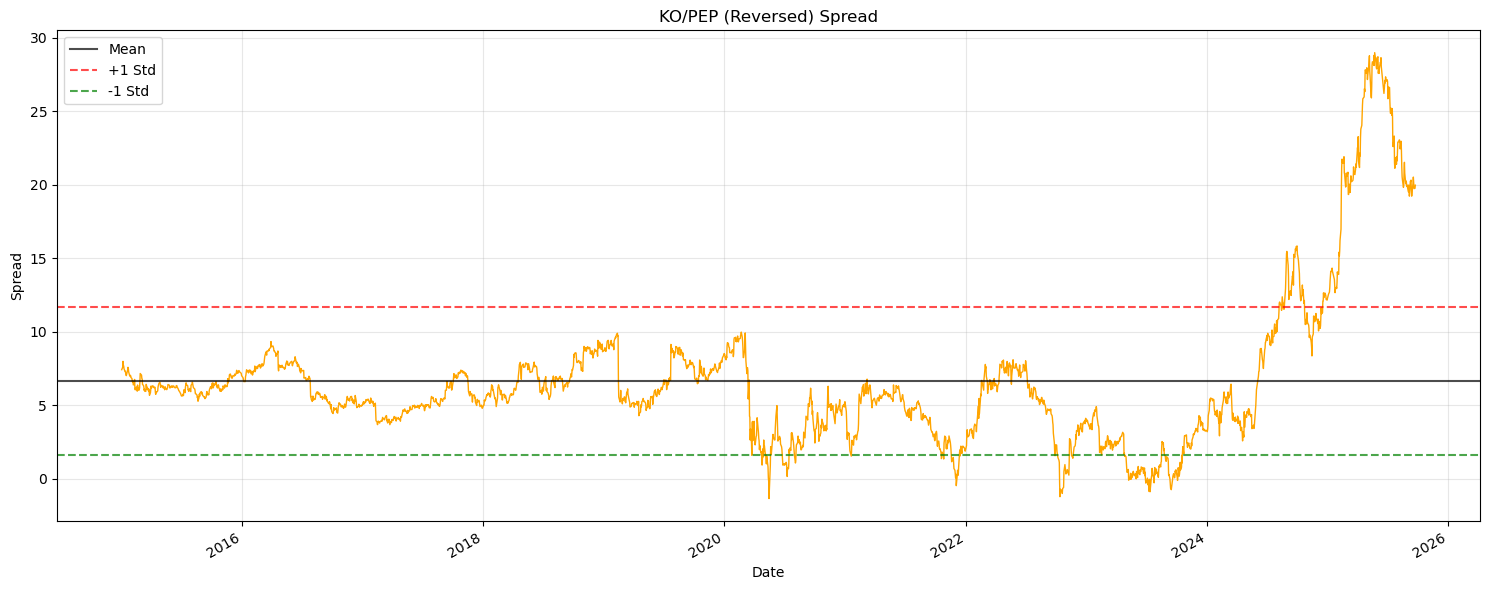

In [36]:
# Plot spread for KO/PEP (Reversed)
plt.figure(figsize=(15, 6))
spread_pair2.plot(title='KO/PEP (Reversed) Spread', linewidth=1, color='orange')
plt.axhline(spread_pair2.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair2.mean() + spread_pair2.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair2.mean() - spread_pair2.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

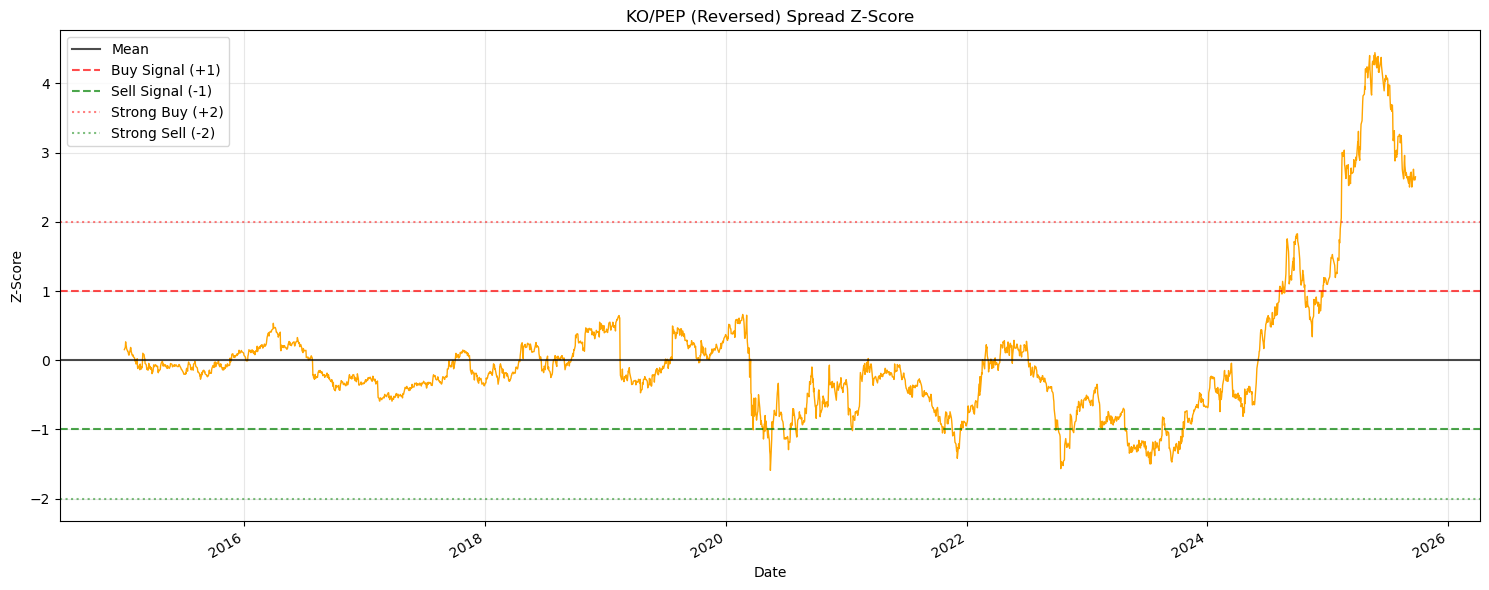

Z-score statistics for KO/PEP (Reversed):
Mean: 0.0000
Std: 1.0002
Min: -1.5928
Max: 4.4460


In [37]:
# Z-score calculation and visualization for KO/PEP (Reversed)
# Calculate z-score of spread
zscore_pair2 = zscore(spread_pair2)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair2.plot(title='KO/PEP (Reversed) Spread Z-Score', linewidth=1, color='orange')
plt.axhline(zscore_pair2.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for KO/PEP (Reversed):")
print(f"Mean: {zscore_pair2.mean():.4f}")
print(f"Std: {zscore_pair2.std():.4f}")
print(f"Min: {zscore_pair2.min():.4f}")
print(f"Max: {zscore_pair2.max():.4f}")

In [38]:
# Trading Strategy for KO/PEP (Reversed)
# Create DataFrame with signal and position

trades_pair2 = pd.DataFrame({
    'signal': zscore_pair2,
    'position': spread_pair2,
    'PEP': S1_pair2,
    'KO': S2_pair2
})

# Add trading side based on z-score thresholds
trades_pair2['side'] = 0.0
trades_pair2.loc[trades_pair2.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair2.loc[trades_pair2.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair2['position_change'] = trades_pair2.position.pct_change()
trades_pair2['strategy_returns'] = trades_pair2.position_change * trades_pair2.side.shift(1)

# Remove NaN values
trades_pair2 = trades_pair2.dropna()

print("KO/PEP (Reversed) Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair2.side != 0).sum()}")
print(f"Long signals: {(trades_pair2.side == 1).sum()}")
print(f"Short signals: {(trades_pair2.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair2.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades_pair2 = trades_pair2[trades_pair2.side != 0]
print(signal_trades_pair2[['signal', 'side', 'strategy_returns']].head(10))

KO/PEP (Reversed) Trading Signals Summary:
Total trading signals: 439
Long signals: 197
Short signals: 242
Signal ratio: 16.28%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-03-24 -1.006388   1.0         -0.000000
2020-04-22 -1.000954   1.0         -0.000000
2020-04-24 -1.139575   1.0         -0.000000
2020-04-28 -1.028041   1.0         -0.000000
2020-05-06 -1.055239   1.0         -0.000000
2020-05-07 -1.123203   1.0         -0.254079
2020-05-08 -1.017996   1.0          0.527286
2020-05-11 -1.122185   1.0         -0.341902
2020-05-12 -1.163350   1.0         -0.205268
2020-05-13 -1.312459   1.0         -0.935560


In [39]:
signal_trades_pair2.tail()

,signal,position,PEP,KO,side,position_change,strategy_returns
Date,,,,,,,
2025-09-17,2.760738,20.518654,141.229996,67.040001,-1.0,0.020122,-0.020122
2025-09-18,2.678088,20.103352,140.729996,66.459999,-1.0,-0.020240,0.020240
2025-09-19,2.604596,19.734071,141.759995,66.430000,-1.0,-0.018369,0.018369
2025-09-22,2.608668,19.754531,141.029999,66.209999,-1.0,0.001037,-0.001037
2025-09-23,2.651141,19.967953,141.899994,66.709999,-1.0,0.010804,-0.010804


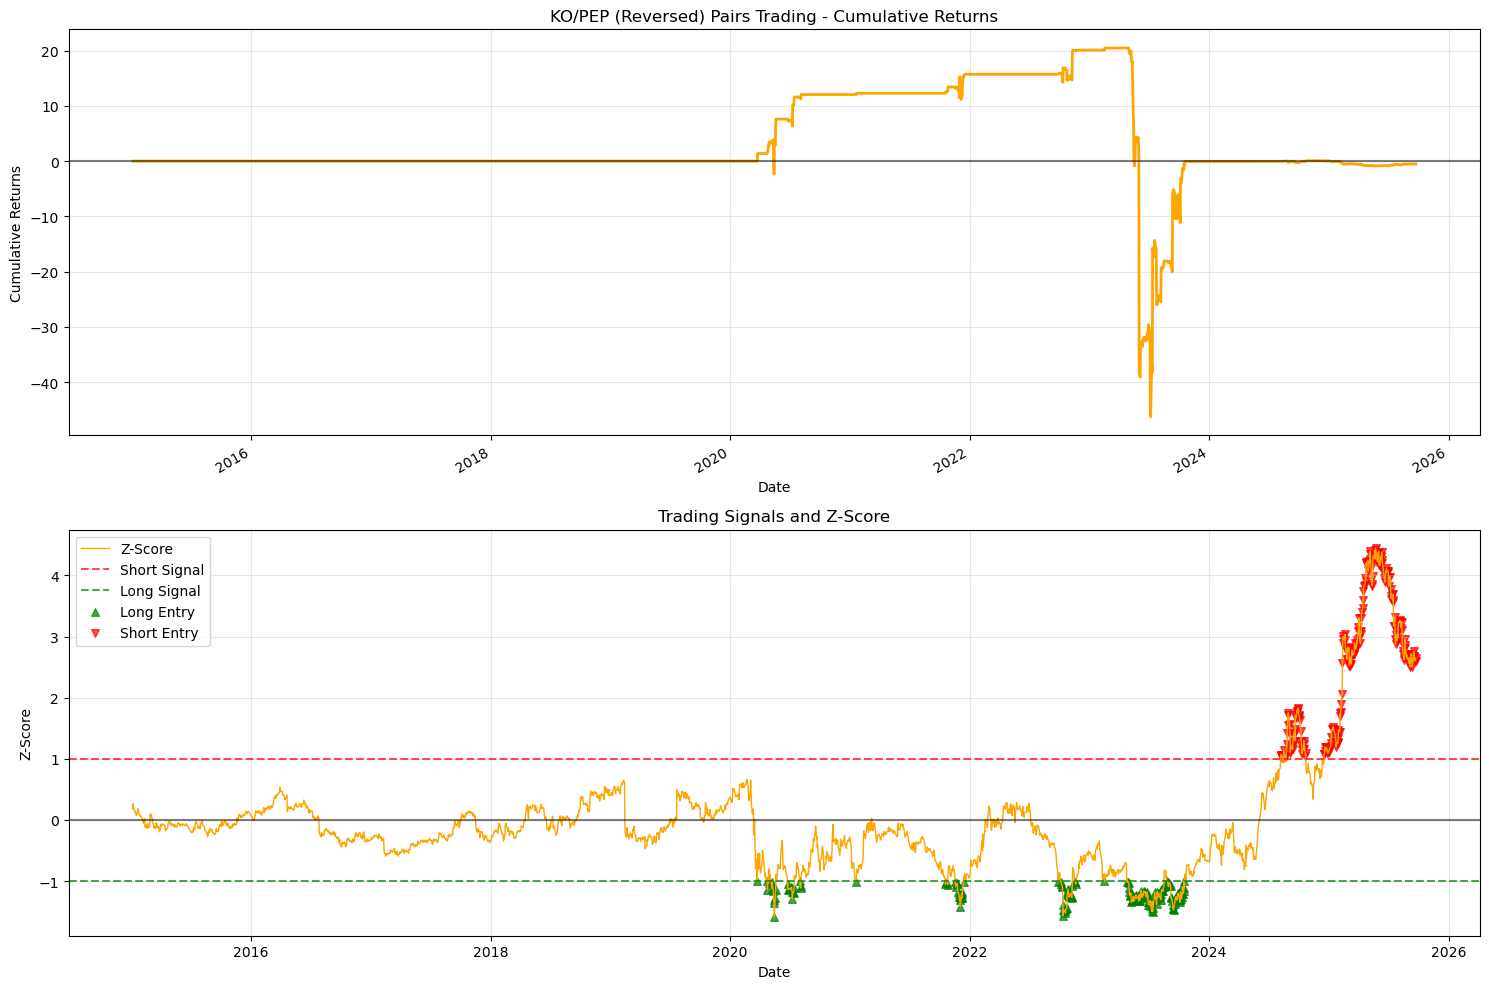


KO/PEP (Reversed) Strategy Performance:
Total Return: -0.5242 (-52.42%)
Annualized Sharpe Ratio: -0.0029
Maximum Drawdown: -66.8002 (-6680.02%)


In [40]:
# Plot strategy performance for KO/PEP (Reversed)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot cumulative returns
cumulative_returns_pair2 = trades_pair2.strategy_returns.cumsum()
cumulative_returns_pair2.plot(ax=axes[0], title='KO/PEP (Reversed) Pairs Trading - Cumulative Returns', 
                              linewidth=2, color='orange')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Cumulative Returns')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair2.index, trades_pair2.signal, linewidth=1, color='orange', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades_pair2 = trades_pair2[trades_pair2.side == 1]
short_trades_pair2 = trades_pair2[trades_pair2.side == -1]
axes[1].scatter(long_trades_pair2.index, long_trades_pair2.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades_pair2.index, short_trades_pair2.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return_pair2 = cumulative_returns_pair2.iloc[-1]
sharpe_ratio_pair2 = trades_pair2.strategy_returns.mean() / trades_pair2.strategy_returns.std() * np.sqrt(252)
max_drawdown_pair2 = (cumulative_returns_pair2 - cumulative_returns_pair2.expanding().max()).min()

print(f"\nKO/PEP (Reversed) Strategy Performance:")
print(f"Total Return: {total_return_pair2:.4f} ({total_return_pair2*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_pair2:.4f}")
print(f"Maximum Drawdown: {max_drawdown_pair2:.4f} ({max_drawdown_pair2*100:.2f}%)")

## Strategy Comparison & Key Insights

### Two Approaches Analyzed:
1. **PEP/KO Strategy**: PEP as dependent variable, KO as independent
2. **KO/PEP Strategy**: KO as dependent variable, PEP as independent (Reversed)

### Educational Takeaways:
- **Hedge Ratio Sensitivity**: The choice of dependent/independent variable significantly affects the hedge ratio and spread characteristics
- **Mean Reversion**: Both approaches should theoretically produce similar risk-adjusted returns due to the underlying cointegration relationship
- **Implementation Flexibility**: Pairs trading strategies can be implemented from either direction, providing portfolio managers with tactical options

### Real-World Considerations:
- **Liquidity**: Choose the more liquid stock as the base for easier execution
- **Volatility**: Consider which direction provides better risk management
- **Transaction Costs**: Factor in bid-ask spreads and execution costs for both securities
- **Market Conditions**: Strategy performance may vary across different market regimes

*This comparative analysis demonstrates the robustness and flexibility of pairs trading methodologies in quantitative finance.*